# Modeling!

In [9]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
import nltk
from sklearn.model_selection import PredefinedSplit
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk import PorterStemmer
from sklearn.kernel_approximation import RBFSampler
from copy import deepcopy

from scipy.stats import uniform
from scipy.stats import randint

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
import random
from sklearn.linear_model import SGDClassifier
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tillgrutschus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Splitting the data into train and test sets

In [2]:
# loading the dataset
dataset_pd = pd.read_parquet('dataset/dataset_labeled.parquet')
dataset_pd.head()


,page_count,figure_count,author_count,year,month,day,text,page_imputed,citation_bucket
doi,,,,,,,,,
10.1002/adfm.202001307,25.0,13.0,5,2020,7,30,"Qinghua Zhao, Wanqi Jie, Tao Wang, Andres Cast...",False,high
10.1002/cphc.200900857,15.0,4.0,8,2010,2,4,"Haifeng Ma, Thomas Brugger, Simon Berner, Yun ...",True,high
10.1002/prop.200710532,5.0,0.0,2,2015,5,20,"Milovan Vasilic, Marko Vojinovic Interaction o...",False,low
10.1007/978-3-030-30493-5_44,15.0,0.0,3,2019,12,3,"Itay Mosafi, Eli David, Nathan S. Netanyahu De...",True,low
10.1007/s00025-018-0843-4,15.0,0.0,2,2018,6,8,Deepshikha and Lalit K. Vashisht Weaving K-fra...,True,high


Train set size: 0.90
Test set size: 0.10


Text(0, 0.5, '')

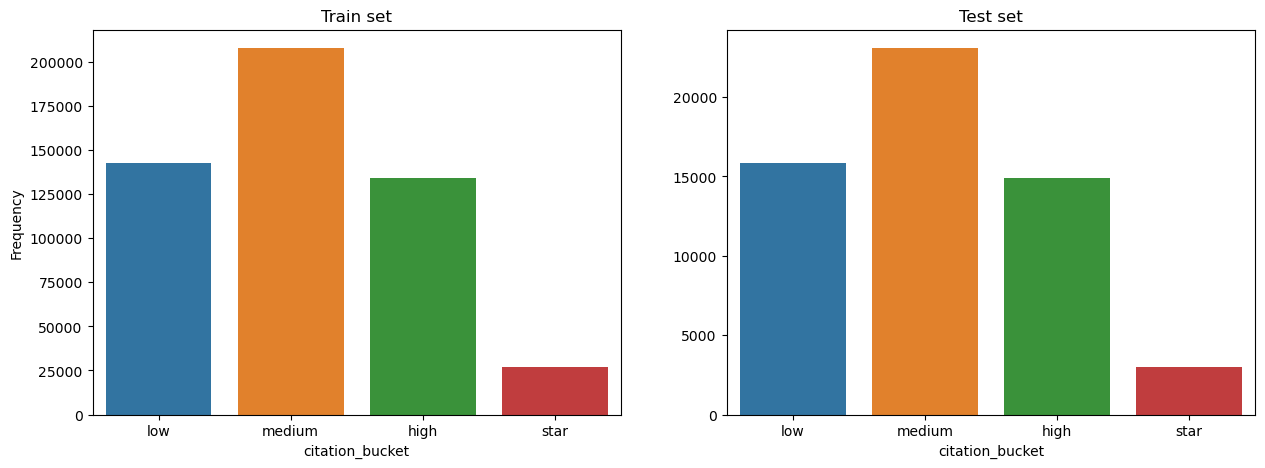

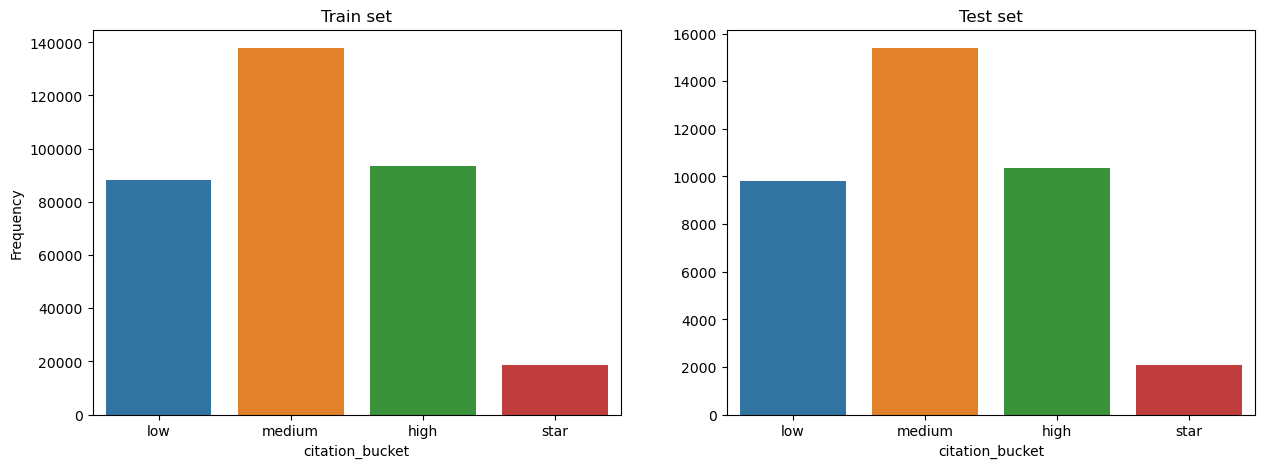

In [5]:
TRAIN_RATIO = 0.9
TEST_RATIO = 0.1

# split the dataset into train and test sets
train_df, test_df = train_test_split(
    dataset_pd,
    test_size=TEST_RATIO,
    random_state=42,
    stratify=dataset_pd["citation_bucket"],
)

print(f"Train set size: {len(train_df) / len(dataset_pd):.2f}")
print(f"Test set size: {len(test_df) / len(dataset_pd):.2f}")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="citation_bucket", data=train_df, ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_title("Train set")
sns.countplot(x="citation_bucket", data=test_df, ax=ax[1])
ax[1].set_title("Test set")
ax[1].set_ylabel("")

filtered_train_df = train_df[train_df["page_imputed"] == False]
filtered_test_df = test_df[test_df["page_imputed"] == False]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="citation_bucket", data=filtered_train_df, ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_title("Train set")
sns.countplot(x="citation_bucket", data=filtered_test_df, ax=ax[1])
ax[1].set_title("Test set")
ax[1].set_ylabel("")



In [6]:
# save the individual sets
train_df.to_parquet("dataset/train.parquet")
test_df.to_parquet("dataset/test.parquet")


## Building the Pipeline

The following models / algorithms will be tried:
 
 **Models**:
 - SVM
 - Multinomial Naive Bayes

**Vectorizers**:
  - Count Vectorizer -> We will not use the CountVectorizer as the SparseMatrix cannot be scaled; we will use the TF-IDF Vectorizer instead
  - TF-IDF Vectorizer

**Dimensionality Reduction**:
  - Stopword removal
  - Lemmatization
  - Stemming

**Scaling:**
  - Standard Scaler

**Metrics:**
  - Accuracy
  - Precision
  - Recall
  - F1 Score

### Pipeline

- **Ratio attributes**: ["page_count", "figure_count", "author_count"]
- **Date attributes**: ["year", "month", "day"]
- **Text attributes**: ["text"]
- **Label**: ["citation_bucket"]

[Ratio] -> [StandardScaler] -> [Model]

Since the three attributes are actually ordinal (not categorical), we treat them as numerical attributes.

[Date] -> [StandardScaler] -> [Model]

[Text] -> [Vectorizer (w/ stopword removal, lemmatization, stemming)] -> [Model]

[Label] -> [OrdinalEncoder] -> [Model]



In [2]:
ratio_columns = ["page_count", "figure_count", "author_count"]
date_columns = ["year", "month", "day"]
text_columns = "text"
label_columns = ["citation_bucket"]

# Ratio
ratio_pipe = Pipeline(
    [
        ("scaler", MinMaxScaler()),
    ]
)

# Date
date_pipe = Pipeline(
    [
        ("scaler", MinMaxScaler()),
    ]
)

# Text
text_pipe = Pipeline(
    [
        ("vectorizer", TfidfVectorizer())
    ]
)

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("ratio", ratio_pipe, ratio_columns),
        ("date", date_pipe, date_columns),
        ("text", text_pipe, text_columns),
    ], n_jobs=-1
)

# Total pipeline
model = LinearSVC(
    loss="hinge",
    C=1.0,
    random_state=42
)
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", model),
    ]
)

display(pipeline)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('ratio',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['page_count', 'figure_count',
                                                   'author_count']),
                                                 ('date',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['year', 'month', 'day']),
                                                 ('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'text')])),
                ('model', LinearSVC(loss='hinge', random_state=42))])

## Model training and evaluation


In [3]:
import os
import pickle

def save_model(model, folder_path):
    # get a list of all files in the folder
    files = os.listdir(folder_path)
    # get the largest number in the filenames
    max_num = max([int(f.split('.')[0]) for f in files if f.endswith('.pkl')] + [0])
    # create a filename for the new model
    filename_model = f"{max_num + 1}.pkl"
    # save the model and parameters
    with open(os.path.join(folder_path, filename_model), 'wb') as f:
        pickle.dump(model, f)

def load_model(model_number, folder_path):
    # create the file path
    file_path = os.path.join(folder_path, str(model_number))
    # load the model and parameters from the file
    with open(file_path + ".pkl", 'rb') as f:
        model = pickle.load(f)
    return model


### Filtering out imputed data

We have noticed that the computation time for the full dataset is too long. Thus, we have filtered out the imputed page counts to reduce computational costs.

In [4]:
train_df = pd.read_parquet("dataset/train.parquet")
train_df = train_df[train_df["page_imputed"] == False]

print(f"Train set absolute size: {len(train_df)}")



Train set absolute size: 338052


### First, naive training!

In [11]:
trained = pipeline.fit(train_df, train_df["citation_bucket"])
save_model(trained, "models")


In [12]:
trained.score(val_df, val_df["citation_bucket"])


0.5118747512272788

### Grid Search!

#### Creating a custom text preprocessor

In [40]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()

    def __call__(self, doc):
        token_pattern = r"(?u)\b\w\w+\b"
        return [
            self.wnl.lemmatize(t)
            for t in nltk.regexp_tokenize(doc, token_pattern)
        ]


class StemmingTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.PorterStemmer()

    def __call__(self, doc):
        token_pattern = r"(?u)\b\w\w+\b"
        return [
            self.wnl.stem(t)
            for t in nltk.regexp_tokenize(doc, token_pattern)
        ]

test_stemmer = StemmingTokenizer()
test_lemmatizer = LemmaTokenizer()
print(test_stemmer("Hey sweetheart, have I showed you how I shower?"))
print(test_lemmatizer("Hey sweetheart, have I showed you how I shower?"))


['hey', 'sweetheart', 'have', 'show', 'you', 'how', 'shower']
['Hey', 'sweetheart', 'have', 'showed', 'you', 'how', 'shower']


In [42]:
%timeit test_stemmer("Hey sweetheart, have I showed you how I shower?")
%timeit test_lemmatizer("Hey sweetheart, have I showed you how I shower?")


51.3 µs ± 91.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
9.73 µs ± 28.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [15]:
trunc_train_df = train_df[:50000]
# Let's compare dim reduction models
print("baseline_tranf_vec")
baseline_tranf_vec = TfidfVectorizer(strip_accents="unicode")
baseline_tranf = baseline_tranf_vec.fit_transform(trunc_train_df["text"])
print(f"Number of features: {baseline_tranf.shape[1]}")
display(f"Sample from the vocabulary: {random.sample(list(baseline_tranf_vec.vocabulary_.keys()), 25)}")


baseline_tranf_vec
Number of features: 156361


"Sample from the vocabulary: ['karuppath', 'mansuripur', 'naser', 'mandell', 'ippocratis', 'vidaexpert', '66006', 'piotto', 'jianyu', 'valio', 'semianalytical', 'biagi', 'yatian', 'pentti', 'photocentre', 'mu_f', 'hunar', 'roati', 'quentin', 'delbo', 'microphonics', 'cerne', 'paradigm', 'hypocenter', '4408']"

In [18]:
# Stop word removal
stop_words = stopwords.words("english")


stop_word_vec = TfidfVectorizer(strip_accents="unicode", stop_words=stop_words)
stop_word_transf = stop_word_vec.fit_transform(trunc_train_df["text"])
print(f"Number of features: {stop_word_transf.shape[1]}")
display(f"Sample from the vocabulary: {random.sample(list(stop_word_vec.vocabulary_.keys()), 25)}")
display(f"Relative dim reduction: {1 - (stop_word_transf.shape[1] / baseline_tranf.shape[1]):.5f}")


Number of features: 156226


"Sample from the vocabulary: ['m62', 'cib', 'olfactory', 'rijcke', 'b881', 'genetically', 'kegerreis', 'celestial', 'entropic', '273m', 'eva', '15au', 'oabo', 'applic', 'lyophobic', 'tsuji', 'foliation', '5194', 'caines', 'pseudoconvex', 'shanhe', 'mcid', 'host', 'jhep0505', 'contrastive']"

'Relative dim reduction: 0.00086'

In [24]:
# Lemmatization
lemma_vec = TfidfVectorizer(strip_accents="unicode", tokenizer=LemmaTokenizer())
lemma_transf = lemma_vec.fit_transform(trunc_train_df["text"])
print(f"Number of features: {lemma_transf.shape[1]}")
display(f"Sample from the vocabulary: {random.sample(list(lemma_vec.vocabulary_.keys()), 25)}")
display(f"Relative dim reduction: {1 - (lemma_transf.shape[1] / baseline_tranf.shape[1]):.5f}")


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of features: 53726


"Sample from the vocabulary: ['l5', 'displacement', 'qmw', 'insulated', 'telemetry', 'pioline', 'implementing', 'axp', 'jamiolkowski', 'concealed', 'semihadronic', 'onodera', '4t', 'chong', '150pc', 'colliding', 'anisotropic', 'expansive', 'pentaquarks', 'cleaning', 'haojing', 'neutralization', 'aisi', 'maro', 'radim']"

'Relative dim reduction: 0.65640'

In [41]:
# Stemming
stem_vec = TfidfVectorizer(strip_accents="unicode", tokenizer=StemmingTokenizer())
stem_transf = stem_vec.fit_transform(trunc_train_df["text"])
print(f"Number of features: {stem_transf.shape[1]}")
display(f"Sample from the vocabulary: {random.sample(list(stem_vec.vocabulary_.keys()), 25)}")
display(f"Relative dim reduction: {1 - (stem_transf.shape[1] / baseline_tranf.shape[1]):.5f}")


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of features: 134201


"Sample from the vocabulary: ['rossier', 'feyzabadi', '136393', 'scarpin', 'gsu', 'he1', 'c70', 'gallego', 'ontivero', 'looser', '5e41', 'ahlborn', '084712', 'photodesorb', 'uzundag', '8054', 'slatteri', 'anheier', 'moncelsi', 'peaker', 'polsar', 'janowiecki', '7006', 'h_q', 'leik']"

'Relative dim reduction: 0.14172'

In [6]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

param_grid_svc = {
    "model": [LinearSVC()],
    "model__C": [0.1, 1.0, 10.0],
    "model__class_weight": [None, "balanced"],
}

param_grid_mnb = {
    "model": [MultinomialNB()],
    "model__alpha": [0.1, 1.0, 10.0],
}

# param_grid_preprocess_ngram = {
#     "preprocessor__text__vectorizer__ngram_range": [(1, 2)],
#     "preprocessor__text__vectorizer__max_features": [1000, 10000],
#     "preprocessor__text__vectorizer__max_df": [0.5, 0.75, 1.0],
#     "preprocessor__text__vectorizer__strip_accents": [None, "unicode"],
# }

param_grid_preprocess_max_df = {
    "preprocessor__text__vectorizer__max_df": [0.5, 0.75, 1.0],
    "preprocessor__text__vectorizer__max_features": [None, 1000, 10000],
    "preprocessor__text__vectorizer__strip_accents": [None, "unicode"],
}

param_grid_preprocess_tokenizer = {
    "preprocessor__text__vectorizer__tokenizer": [
        None,
        LemmaTokenizer(),
        StemmingTokenizer(),
    ],
    "preprocessor__text__vectorizer__stop_words": [None, list(stop_words)],
}

param_grid_scaler_min_max = {
    "preprocessor__ratio__scaler": [MinMaxScaler()],
    "preprocessor__date__scaler": [MinMaxScaler()],
}

param_grid_scaler_std = {
    "preprocessor__ratio__scaler": [StandardScaler()],
    "preprocessor__date__scaler": [StandardScaler()],
}


param_grid = [
    {**param_grid_svc, **param_grid_scaler_min_max, **param_grid_preprocess_max_df},
    {**param_grid_mnb, **param_grid_scaler_min_max, **param_grid_preprocess_max_df},
    {**param_grid_svc, **param_grid_scaler_std, **param_grid_preprocess_max_df},
    {**param_grid_mnb, **param_grid_scaler_std, **param_grid_preprocess_max_df},
    {**param_grid_svc, **param_grid_scaler_min_max, **param_grid_preprocess_tokenizer},
    {**param_grid_mnb, **param_grid_scaler_min_max, **param_grid_preprocess_tokenizer},
    {**param_grid_svc, **param_grid_scaler_std, **param_grid_preprocess_tokenizer},
    {**param_grid_mnb, **param_grid_scaler_std, **param_grid_preprocess_tokenizer},
]


search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, verbose=10, n_jobs=8)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tillgrutschus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Warning - Takes ages!
search.fit(train_df, train_df["citation_bucket"])
save_model(search, "models")


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV 1/3; 1/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 1/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 3/3; 1/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3; 8/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.521 total time=  43.1s
[CV 1/3; 11/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 11/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None
[CV 1/3; 9/432] E

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 73/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.471 total time= 9.1min
[CV 3/3; 75/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 73/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total tim

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 74/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.471 total time= 8.9min
[CV 3/3; 76/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 74/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time= 9.0min
[CV 1/3; 77/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 74/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.471 total time= 9.1min
[CV 2/3; 77/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 75/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time=10.0min
[CV 3/3; 77/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 75/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total ti

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 75/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time= 9.5min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 78/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 1/3; 76/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time= 9.5min
[CV 2/3; 76/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 76/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time= 9.5min
[CV 2/3; 79/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 77/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.503 total time=10.3min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 79/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 77/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 total time=10.2min
[CV 1/3; 80/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 77/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.504 total time=10.4min
[CV 1/3; 78/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503 total time=10.3min
[CV 2/3; 80/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__str

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 79/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.471 total time= 9.0min
[CV 1/3; 81/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 79/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 78/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=10.5min
[CV 3/3; 81/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None
[CV 3/3; 78/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.504 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 80/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.471 total time= 9.1min
[CV 3/3; 82/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 80/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.4

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 80/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.471 total time= 9.0min
[CV 2/3; 83/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 81/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time= 9.7min
[CV 2/3; 81/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time= 9.8min
[CV 3/3; 83/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 81/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time= 9.8min
[CV 2/3; 84/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 1/3; 82/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 82/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512 total time= 9.8min
[CV 1/3; 85/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 82/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time= 9.8min
[CV 2/3; 85/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 83/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.503 total time=10.0min
[CV 3/3; 85/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 83/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 total time=10.1min
[CV 1/3; 86/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 83/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.503 total time=10.7min
[CV 2/3; 86/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode
[CV 1/3; 84/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 85/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.472 total time= 9.7min
[CV 1/3; 87/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 84/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=10.8min
[CV 2/3; 87/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 85/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 tota

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 86/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.472 total time= 9.5min
[CV 3/3; 88/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 3/3; 86/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.472 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 87/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time=10.6min
[CV 3/3; 89/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 87/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.513 total time=10.6min
[CV 1/3; 90/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 3/3; 87/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 88/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.513 total time=10.6min
[CV 1/3; 91/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 88/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time=10.7min
[CV 2/3; 91/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 89/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.503 total time=10.9min
[CV 3/3; 91/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 89/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 tot

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 91/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time= 9.3min
[CV 2/3; 92/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 91/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time= 8.9min
[CV 3/3; 92/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 89/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.503 total time=11.0min
[CV 1/3; 93/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 90/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503 total time=11.0min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 93/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 90/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=11.0min
[CV 3/3; 90/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503 total time=11.0min
[CV 3/3; 93/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorize

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 91/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time= 9.4min
[CV 2/3; 94/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 1/3; 92/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, sco

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 92/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time= 8.5min
[CV 1/3; 95/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 92/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time= 8.4min
[CV 2/3; 95/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 93/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.463 total time=10.3min
[CV 3/3; 95/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 93/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=10.3min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 96/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 3/3; 93/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=10.3min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 96/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 1/3; 94/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=10.4min
[CV 3/3; 96/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicod

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 94/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=10.2min
[CV 1/3; 97/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 3/3; 94/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, sc

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 95/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.464 total time=10.8min
[CV 3/3; 97/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 95/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.466 total time=10.9min
[CV 1/3; 98/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 95/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.464 total time=10.9min
[CV 2/3; 98/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 96/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.464 total time=11.0min
[CV 2/3; 96/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time=10.8min
[CV 3/3; 98/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 96/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time=11.2min
[CV 2/3; 99/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 97/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time= 9.3min
[CV 3/3; 99/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 97/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time= 9.8min
[CV 1/3; 100/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 97/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time= 9.0min
[CV 2/3; 100/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 98/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time= 9.0min
[CV 3/3; 100/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 98/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time= 9.0min
[CV 1/3; 101/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 98/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time= 9.3min
[CV 2/3; 101/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 99/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time=10.7min
[CV 3/3; 101/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 99/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.468 total time=10.8min
[CV 1/3; 102/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 99/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.468 total time=10.5min
[CV 2/3; 102/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 100/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=10.5min
[CV 3/3; 102/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 100/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=10.5min
[CV 1/3; 103/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 100/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.468 total time=10.6min
[CV 2/3; 103/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 101/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.464 total time=10.9min
[CV 3/3; 103/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 101/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=11.1min
[CV 1/3; 104/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 101/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.464 total time=11.2min
[CV 2/3; 104/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 102/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.464 total time=11.3min
[CV 3/3; 104/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 103/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.466 total time= 9.6min
[CV 1/3; 105/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 102/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time=11.5min
[CV 2/3; 105/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 103/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.466 total time= 9.9min
[CV 3/3; 105/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 102/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.464 total time=11.8min
[CV 1/3; 106/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 103/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.466 total time=10.0min
[CV 2/3; 106/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 104/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time= 9.8min
[CV 3/3; 106/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 104/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time=10.0min
[CV 1/3; 107/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 104/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time= 9.7min
[CV 2/3; 107/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 105/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time=11.4min
[CV 3/3; 107/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 105/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=11.5min
[CV 1/3; 108/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 105/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.471 total time=11.3min
[CV 2/3; 108/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 106/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.470 total time=11.0min
[CV 3/3; 108/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 106/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.470 total time=11.0min
[CV 1/3; 109/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 106/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=11.1min
[CV 2/3; 109/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 1/3; 109/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.451 total time=  34.5s
[CV 3/3; 109/432] 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 107/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.464 total time=11.0min
[CV 2/3; 111/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None
[CV 3/3; 110/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.450 total time=  31.3s
[CV 1/3; 111/432]

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 107/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=10.9min
[CV 2/3; 112/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 111/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.443 total time=  29.2s
[CV 3/3; 112/432]

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 123/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.448 total time=  28.8s
[CV 2/3; 124/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 3/3; 107/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.464 total time=10.8min
[CV 2/3; 123/432]

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 124/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.447 total time=  32.1s
[CV 1/3; 125/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.438 total time=  32.2s
[CV 2/3; 126/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 125/432] END model=Multinom

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 126/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.438 total time=  29.4s
[CV 2/3; 108/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time=10.9min
[CV 1/3; 128/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 1

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 163/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.522 total time= 9.8min
[CV 1/3; 168/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 165/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time= 6.8min
[CV 2/3; 168/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 3/3; 166/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, sc

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 167/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.516 total time= 8.3min
[CV 3/3; 170/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 168/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 168/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.515 total time= 8.7min
[CV 3/3; 171/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 169/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, sco

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 172/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time= 7.1min
[CV 3/3; 175/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 173/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, sco

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 175/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.521 total time=10.1min
[CV 2/3; 178/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 175/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.523 total time=11.5min
[CV 3/3; 178/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 176/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, sco

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 177/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.513 total time= 7.8min
[CV 3/3; 179/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 177/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 177/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time= 9.2min
[CV 3/3; 180/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 178/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, sc

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 178/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512 total time= 8.6min
[CV 3/3; 181/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 179/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.517 total time= 8.0min
[CV 1/3; 182/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode
[CV 3/3; 179/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 181/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.493 total time= 8.3min
[CV 3/3; 183/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 181/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.493 total time= 8.7min
[CV 1/3; 184/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 182/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.493 total time= 8.3min
[CV 2/3; 184/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 181/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.492 total time=10.2min
[CV 3/3; 184/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 182/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.492 total time= 8.2min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 185/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 182/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.493 total time= 8.7min
[CV 2/3; 185/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accen

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 183/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time= 7.3min
[CV 3/3; 185/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 183/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.468 total time= 7.5min
[CV 1/3; 186/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 183/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.468 total time= 7.6min
[CV 2/3; 186/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 184/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.470 total time= 6.5min
[CV 3/3; 186/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 184/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.468 total time= 7.3min
[CV 1/3; 187/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 184/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.468 total time= 7.1min
[CV 2/3; 187/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 185/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.477 total time= 7.6min
[CV 3/3; 187/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 185/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.478 total time= 7.2min
[CV 1/3; 188/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 185/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.479 total time= 9.2min
[CV 2/3; 188/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 186/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.478 total time= 8.0min
[CV 3/3; 188/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 186/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.479 total time= 7.8min
[CV 1/3; 189/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 186/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.478 total time= 8.2min
[CV 2/3; 189/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 187/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.493 total time= 8.7min
[CV 3/3; 189/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 187/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.494 total time=10.6min
[CV 1/3; 190/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 188/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.494 total time= 8.0min
[CV 1/3; 188/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.493 total time= 8.5min
[CV 2/3; 190/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preproce

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 187/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.492 total time=10.0min
[CV 1/3; 191/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 189/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time= 7.9min
[CV 2/3; 191/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 188/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.492 total time= 9.1min
[CV 3/3; 191/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 189/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time= 7.9min
[CV 1/3; 192/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 189/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.468 total time= 8.1min
[CV 2/3; 192/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 190/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.470 total time= 6.7min
[CV 3/3; 192/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 190/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.468 total time= 6.7min
[CV 1/3; 193/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 190/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time= 7.0min
[CV 2/3; 193/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 191/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.479 total time= 7.2min
[CV 1/3; 191/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.478 total time= 8.0min
[CV 3/3; 193/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor_

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 191/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.478 total time= 7.8min
[CV 2/3; 194/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 192/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.478 total time= 7.9min
[CV 3/3; 194/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 192/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.479 total time= 9.0min
[CV 1/3; 195/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 193/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.494 total time= 9.3min
[CV 2/3; 195/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 192/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.478 total time=10.0min
[CV 3/3; 195/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 193/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.494 total time=10.6min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 196/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 1/3; 194/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.494 total time= 9.5min
[CV 2/3; 196/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_acce

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 193/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.492 total time=10.9min
[CV 3/3; 196/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 194/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.492 total time= 9.1min
[CV 1/3; 197/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 194/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.494 total time=10.6min
[CV 2/3; 197/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 195/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time= 7.9min
[CV 3/3; 197/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 195/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time= 7.9min
[CV 1/3; 198/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 195/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time= 7.9min
[CV 2/3; 198/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 196/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.470 total time= 7.7min
[CV 3/3; 198/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 196/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time= 8.5min
[CV 1/3; 199/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 196/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time= 8.6min
[CV 2/3; 199/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 197/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.480 total time= 7.7min
[CV 3/3; 199/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 197/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.479 total time= 9.4min
[CV 1/3; 200/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 197/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.479 total time= 8.7min
[CV 2/3; 200/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 198/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.479 total time= 7.6min
[CV 3/3; 200/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 198/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.480 total time= 8.7min
[CV 1/3; 201/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 198/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.478 total time= 9.4min
[CV 2/3; 201/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 199/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.500 total time=11.5min
[CV 3/3; 201/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 199/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.501 total time=11.5min
[CV 1/3; 202/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 199/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.501 total time=11.5min
[CV 2/3; 202/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 200/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.500 total time=11.4min
[CV 3/3; 202/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 200/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.501 total time=11.3min
[CV 1/3; 203/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 200/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.501 total time=11.3min
[CV 2/3; 203/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 201/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time=10.0min
[CV 3/3; 203/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 201/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time= 9.9min
[CV 1/3; 204/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 201/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time= 9.8min
[CV 2/3; 204/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 202/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time= 9.7min
[CV 3/3; 204/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 202/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time= 9.7min
[CV 1/3; 205/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 202/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time= 9.7min
[CV 2/3; 205/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 203/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 total time=10.5min
[CV 3/3; 205/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 203/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.508 total time=10.6min
[CV 1/3; 206/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 203/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 total time=10.6min
[CV 2/3; 206/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 204/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=10.6min
[CV 3/3; 206/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 204/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.508 total time=10.9min
[CV 1/3; 207/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 204/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=10.9min
[CV 2/3; 207/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 205/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.500 total time=11.6min
[CV 3/3; 207/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 205/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.501 total time=11.6min
[CV 1/3; 208/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 205/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.502 total time=11.7min
[CV 2/3; 208/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 206/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.500 total time=11.6min
[CV 3/3; 208/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 206/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.501 total time=11.6min
[CV 1/3; 209/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 206/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.502 total time=11.5min
[CV 2/3; 209/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 207/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time=10.2min
[CV 3/3; 209/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 207/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time=10.2min
[CV 1/3; 210/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 207/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time=10.1min
[CV 2/3; 210/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 208/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512 total time=10.1min
[CV 3/3; 210/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 208/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512 total time=10.1min
[CV 1/3; 211/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 208/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time=10.1min
[CV 2/3; 211/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 209/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 total time=10.5min
[CV 3/3; 211/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 209/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.509 total time=10.7min
[CV 1/3; 212/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 209/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 total time=10.7min
[CV 2/3; 212/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 210/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=10.8min
[CV 3/3; 212/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 210/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.509 total time=11.0min
[CV 1/3; 213/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 210/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=11.0min
[CV 2/3; 213/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 211/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.501 total time=12.1min
[CV 3/3; 213/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 211/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.502 total time=12.2min
[CV 1/3; 214/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 211/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.502 total time=12.2min
[CV 2/3; 214/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 212/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.501 total time=12.0min
[CV 3/3; 214/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 212/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.502 total time=12.0min
[CV 1/3; 215/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 213/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time=10.9min
[CV 3/3; 212/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.502 total time=11.9min
[CV 2/3; 215/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vecto

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 213/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time=10.8min
[CV 1/3; 216/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 213/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time=10.7min
[CV 2/3; 216/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 214/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512 total time=10.6min
[CV 3/3; 216/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 214/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512 total time=10.6min
[CV 1/3; 217/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 214/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512 total time=10.6min
[CV 2/3; 217/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 215/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 total time=10.8min
[CV 3/3; 217/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 215/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.509 total time=10.9min
[CV 3/3; 215/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 total time=10.9min
[CV 1/3; 218/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vec

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 216/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=10.9min
[CV 3/3; 218/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 216/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.509 total time=11.1min
[CV 1/3; 219/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 216/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=11.1min
[CV 2/3; 219/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 217/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.483 total time=11.4min
[CV 3/3; 219/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 217/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.485 total time=11.5min
[CV 1/3; 220/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 217/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.484 total time=11.4min
[CV 2/3; 220/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 218/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.484 total time=11.4min
[CV 3/3; 220/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 218/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accent

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 218/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.484 total time=11.4min
[CV 2/3; 221/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 219/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=10.2min
[CV 3/3; 221/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 219/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.468 total time=10.1min
[CV 1/3; 222/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 219/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=10.1min
[CV 2/3; 222/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 220/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=10.1min
[CV 3/3; 222/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 220/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.468 total time=10.0min
[CV 1/3; 223/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 220/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.467 total time=10.0min
[CV 2/3; 223/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 221/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=10.8min
[CV 3/3; 223/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 221/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=10.8min
[CV 1/3; 224/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 221/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=10.8min
[CV 2/3; 224/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 222/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.467 total time=10.9min
[CV 3/3; 224/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 222/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=11.0min
[CV 1/3; 225/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 222/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.467 total time=11.1min
[CV 2/3; 225/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 223/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.484 total time=11.6min
[CV 3/3; 225/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 223/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.485 total time=11.6min
[CV 1/3; 226/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 223/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.484 total time=11.6min
[CV 2/3; 226/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 224/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.484 total time=11.5min
[CV 3/3; 226/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 224/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.485 total time=11.6min
[CV 1/3; 227/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 224/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.484 total time=11.5min
[CV 2/3; 227/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None
[CV 1/3; 225/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accen

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 225/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=10.6min
[CV 1/3; 228/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 225/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.468 total time=10.4min
[CV 2/3; 228/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 226/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.470 total time=10.4min
[CV 3/3; 228/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 226/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=10.4min
[CV 1/3; 229/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 226/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.468 total time=10.4min
[CV 2/3; 229/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 227/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=10.9min
[CV 3/3; 229/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 227/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=10.9min
[CV 3/3; 227/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=10.9min
[CV 1/3; 230/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor_

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 228/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.467 total time=11.0min
[CV 3/3; 230/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 228/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=11.1min
[CV 1/3; 231/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 228/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.467 total time=11.2min
[CV 2/3; 231/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 229/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.485 total time=12.1min
[CV 3/3; 231/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 229/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.486 total time=12.1min
[CV 1/3; 232/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 229/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.485 total time=12.1min
[CV 2/3; 232/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 230/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.485 total time=12.0min
[CV 3/3; 232/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 230/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accent

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 230/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.485 total time=12.0min
[CV 2/3; 233/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 231/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time=11.2min
[CV 3/3; 233/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 231/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=11.0min
[CV 1/3; 234/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 231/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=11.0min
[CV 2/3; 234/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 232/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.470 total time=11.0min
[CV 3/3; 234/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 232/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=11.0min
[CV 1/3; 235/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 232/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=11.0min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 235/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 1/3; 233/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.468 total time=11.1min
[CV 3/3; 235/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 233/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time=11.3min
[CV 1/3; 236/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 233/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=11.2min
[CV 2/3; 236/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 234/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.468 total time=11.3min
[CV 3/3; 236/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 234/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.470 total time=11.5min
[CV 1/3; 237/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 234/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.467 total time=11.6min
[CV 2/3; 237/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 235/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.471 total time=11.2min
[CV 3/3; 237/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 235/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=11.2min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 238/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 3/3; 235/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.471 total time=11.2min
[CV 2/3; 238/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 236/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.471 total time=11.1min
[CV 3/3; 238/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 236/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=11.0min
[CV 1/3; 239/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 236/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.471 total time=10.9min
[CV 2/3; 239/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 237/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time=10.7min
[CV 3/3; 239/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 237/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time=10.7min
[CV 1/3; 240/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 237/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time=10.5min
[CV 2/3; 240/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 238/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time=10.5min
[CV 3/3; 240/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 238/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicod

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 238/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.510 total time=10.5min
[CV 2/3; 241/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 239/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.503 total time=11.6min
[CV 3/3; 241/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 239/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.505 total time=11.6min
[CV 1/3; 242/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 239/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.503 total time=11.7min
[CV 2/3; 242/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 240/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503 total time=11.7min
[CV 3/3; 242/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 240/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=11.9min
[CV 1/3; 243/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 241/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.471 total time=11.4min
[CV 2/3; 243/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 240/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503 total time=11.9min
[CV 3/3; 243/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 241/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=11.4min
[CV 1/3; 244/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 241/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.471 total time=11.4min
[CV 2/3; 244/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 242/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.471 total time=11.3min
[CV 3/3; 244/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 242/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=11.3min
[CV 1/3; 245/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 242/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.471 total time=11.2min
[CV 2/3; 245/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 243/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.513 total time=11.0min
[CV 3/3; 245/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 243/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time=11.0min
[CV 1/3; 246/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 243/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time=11.0min
[CV 2/3; 246/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 244/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512 total time=11.0min
[CV 3/3; 246/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 244/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.513 total time=10.9min
[CV 1/3; 247/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 244/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time=10.9min
[CV 2/3; 247/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 245/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.503 total time=11.5min
[CV 3/3; 247/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 245/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.506 total time=11.6min
[CV 1/3; 248/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 245/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.504 total time=11.7min
[CV 2/3; 248/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 246/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503 total time=11.8min
[CV 3/3; 248/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 246/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=11.9min
[CV 1/3; 249/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 246/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503 total time=12.0min
[CV 2/3; 249/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 247/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.472 total time=11.7min
[CV 3/3; 249/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 247/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time=11.8min
[CV 1/3; 250/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 247/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.472 total time=11.7min
[CV 2/3; 250/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 248/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.472 total time=11.6min
[CV 3/3; 250/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 248/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.471 total time=11.6min
[CV 1/3; 251/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 248/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.472 total time=11.4min
[CV 2/3; 251/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 249/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time=11.6min
[CV 3/3; 251/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 249/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.511 total time=11.6min
[CV 1/3; 252/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 249/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.512 total time=11.4min
[CV 2/3; 252/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 250/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.512 total time=11.4min
[CV 3/3; 252/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 250/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.513 total time=11.4min
[CV 1/3; 253/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 250/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.511 total time=11.4min
[CV 2/3; 253/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 251/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.503 total time=11.9min
[CV 3/3; 253/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 251/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.505 total time=11.8min
[CV 1/3; 254/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 251/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.504 total time=12.0min
[CV 2/3; 254/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 252/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503 total time=12.1min
[CV 3/3; 254/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 252/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.506 total time=12.2min
[CV 1/3; 255/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 252/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.503 total time=12.3min
[CV 2/3; 255/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 253/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time=11.2min
[CV 3/3; 255/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 253/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time=11.2min
[CV 1/3; 256/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 253/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time=11.1min
[CV 2/3; 256/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 254/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time=11.1min
[CV 3/3; 256/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 254/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time=11.0min
[CV 1/3; 257/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 254/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time=11.0min
[CV 2/3; 257/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 255/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.473 total time=10.8min
[CV 3/3; 257/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 255/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.477 total time=10.7min
[CV 1/3; 258/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 255/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.477 total time=10.6min
[CV 2/3; 258/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 256/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.473 total time=10.7min
[CV 3/3; 258/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 256/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.477 total time=10.6min
[CV 1/3; 259/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 256/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.477 total time=10.6min
[CV 2/3; 259/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 257/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=11.8min
[CV 3/3; 259/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 257/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time=11.9min
[CV 1/3; 260/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 257/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.471 total time=12.0min
[CV 2/3; 260/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 258/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.464 total time=12.0min
[CV 3/3; 260/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 258/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=12.1min
[CV 1/3; 261/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 258/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.469 total time=12.2min
[CV 2/3; 261/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 259/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time=11.3min
[CV 3/3; 261/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 259/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.466 total time=11.3min
[CV 1/3; 262/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 259/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.465 total time=11.3min
[CV 2/3; 262/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 260/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time=11.2min
[CV 3/3; 262/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 260/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.465 total time=11.2min
[CV 1/3; 263/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 260/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time=11.0min
[CV 2/3; 263/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 261/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.480 total time=11.2min
[CV 3/3; 263/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 261/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.480 total time=11.1min
[CV 1/3; 264/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 261/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.469 total time=11.0min
[CV 2/3; 264/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 262/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.456 total time=11.0min
[CV 3/3; 264/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 262/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.473 total time=11.0min
[CV 1/3; 265/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 262/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.479 total time=11.0min
[CV 2/3; 265/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 263/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.467 total time=11.8min
[CV 3/3; 265/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 263/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.471 total time=11.9min
[CV 1/3; 266/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 263/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.468 total time=12.0min
[CV 2/3; 266/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 264/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.464 total time=12.1min
[CV 3/3; 266/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 264/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.468 total time=12.3min
[CV 1/3; 267/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 264/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.468 total time=12.3min
[CV 2/3; 267/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 265/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.466 total time=11.8min
[CV 3/3; 267/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 265/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.466 total time=11.8min
[CV 1/3; 268/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 265/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=0.466 total time=11.8min
[CV 2/3; 268/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 266/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time=11.8min
[CV 3/3; 268/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 266/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time=11.7min
[CV 1/3; 269/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 266/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.466 total time=11.6min
[CV 2/3; 269/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 267/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.479 total time=11.8min
[CV 3/3; 269/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 267/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.480 total time=11.7min
[CV 1/3; 270/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 267/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=0.479 total time=11.8min
[CV 2/3; 270/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 268/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.481 total time=11.7min
[CV 3/3; 270/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 268/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.479 total time=11.7min
[CV 1/3; 271/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 1/3; 271/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=nan total time=  20.2s
[CV 2/3;

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 268/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=0.463 total time=11.7min
[CV 3/3; 271/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=nan total time=  20.2s
[CV 1/3; 272/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 269/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.466 total time=12.3min
[CV 1/3; 276/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2/3; 275/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=nan total time=  20.5s
[CV 3

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 277/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=nan total time=  20.2s
[CV 2/3; 269/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.470 total time=12.2min
[CV 1/3; 278/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode
[CV 2

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 269/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=None;, score=0.462 total time=12.3min
[CV 3/3; 284/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  19.5s
[CV 1/3; 285/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=None;, score=n

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 286/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  16.8s
[CV 2/3; 286/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  17.2s
[CV 3/3; 286/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=1000, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  16.9

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 294/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  18.0s
[CV 3/3; 295/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None
[CV 2/3; 294/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.5, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  18.0s
[CV 1/3; 296/432] START mod

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 300/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=0.75, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  17.8s
[CV 3/3; 302/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=unicode
[CV 1/3; 301/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=None, preprocessor__text__vectorizer__strip_accents=None;, score=nan total time=  17.8s
[CV 1/3; 303/432] START mode

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 326/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x1394594d0>
[CV 2/3; 326/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x1394594d0>;, score=nan total time=   0.0s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 326/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x12d66ff10>
[CV 3/3; 326/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x12d66ff10>;, score=nan total time=   0.0s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 327/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x139063f10>
[CV 1/3; 324/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  20.0s
[CV 2/3; 327/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x33473bf50>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 324/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  20.3s
[CV 3/3; 327/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x168044890>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 324/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__max_df=1.0, preprocessor__text__vectorizer__max_features=10000, preprocessor__text__vectorizer__strip_accents=unicode;, score=nan total time=  21.0s
[CV 1/3; 328/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "yo

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 329/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'he

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 329/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'he

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 330/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'he

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 330/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'he

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 1/3; 328/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 328/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 332/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x16f0964d0>
[CV 2/3; 332/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x16f0964d0>;, score=nan total time=   0.1s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 332/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2ac1a2cd0>
[CV 3/3; 332/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2ac1a2cd0>;, score=nan total time=   0.1s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 333/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x30c3dd790>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 331/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.492 total time=  35.4s
[CV 2/3; 333/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10a316210>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 327/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x139063f10>;, score=0.522 total time=10.1min
[CV 3/3; 327/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x168044890>;, score=0.521 total time=10.0min
[CV 3/3; 333/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x282c4d610

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 334/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 335/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 335/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 336/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 330/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 336/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 334/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 338/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x177618790>
[CV 2/3; 338/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x177618790>;, score=nan total time=   0.2s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 338/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x177312c90>
[CV 3/3; 338/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x177312c90>;, score=nan total time=   0.2s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 339/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x1775f3f10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 337/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.501 total time= 1.3min
[CV 2/3; 339/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x285879f50>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 337/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.502 total time= 1.3min
[CV 3/3; 339/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x16c09dad0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 337/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.502 total time= 1.2min
[CV 1/3; 340/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 341/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'he

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 341/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'he

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 342/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'he

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 333/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x282c4d610>;, score=0.493 total time=10.1min
[CV 2/3; 342/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'be

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 1/3; 336/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 336/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 344/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x28eecead0>
[CV 2/3; 344/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x28eecead0>;, score=nan total time=   0.0s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 344/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x28eece210>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 344/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x28eece210>;, score=nan total time=   0.2s
[CV 1/3; 345/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x30e3bf310>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 339/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x1775f3f10>;, score=0.506 total time=10.8min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 345/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10a366ed0>
[CV 2/3; 339/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x285879f50>;, score=0.505 total time=10.9min
[CV 3/3; 345/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x15cf7ff10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 339/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x16c09dad0>;, score=0.504 total time=10.8min
[CV 1/3; 346/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'be

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 347/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 347/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 348/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 346/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 1/3; 342/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 348/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 350/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x177376b10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 350/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x177376b10>;, score=nan total time=   0.3s
[CV 3/3; 350/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x177953f10>
[CV 3/3; 350/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x177953f10>;, score=nan total time=   0.1s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 351/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x177268a10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 345/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x15cf7ff10>;, score=0.491 total time=11.2min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 351/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x12e0d1f50>
[CV 1/3; 348/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'in

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 348/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 349/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.470 total time= 7.7min
[CV 1/3; 353/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'sh

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 353/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'h

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 353/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'her

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 354/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'h

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 349/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.472 total time= 7.5min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 354/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'h

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 352/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'her

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 351/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x12e0d1f50>;, score=0.475 total time=17.8min
[CV 3/3; 355/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None
[CV 1/3; 351/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x177268a10>;, score=0.475 total time=18.3min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 356/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15af8f610>
[CV 1/3; 356/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15af8f610>;, score=nan total time=   0.1s
[CV 2/3; 356/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15af8d050>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 356/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15af8d050>;, score=nan total time=   0.9s
[CV 3/3; 356/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15af276d0>
[CV 3/3; 356/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15af276d0>;, score=nan total time=   0.4s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 357/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x16002edd0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 355/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.466 total time= 8.7min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 357/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x108f19a10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 355/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.466 total time= 8.4min
[CV 3/3; 357/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2d1d6e3d0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 351/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2ae017f10>;, score=0.475 total time=18.8min
[CV 1/3; 358/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 354/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'her

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 355/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.466 total time= 7.4min
[CV 1/3; 359/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'di

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 359/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves'

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 359/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 360/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves'

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 354/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'her

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 358/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 358/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 362/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15b237f10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 362/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15b237f10>;, score=nan total time=   0.3s
[CV 3/3; 362/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15a1c0450>
[CV 3/3; 362/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15a1c0450>;, score=nan total time=   0.1s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 363/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x15a9c9c10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 358/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 357/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x16002edd0>;, score=0.471 total time=17.8min
[CV 3/3; 363/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x17784f010>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 357/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x108f19a10>;, score=0.471 total time=17.4min
[CV 1/3; 364/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll",

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 365/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 365/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 365/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 366/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 364/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarn

[CV 1/3; 363/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x15a9c9c10>;, score=0.458 total time=10.0min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 366/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 368/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2aa2edbd0>
[CV 2/3; 368/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2aa2edbd0>;, score=nan total time=   0.1s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 368/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2aa2ed2d0>
[CV 3/3; 368/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2aa2ed2d0>;, score=nan total time=   0.3s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 369/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x30f006cd0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 367/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.447 total time=  23.4s
[CV 2/3; 369/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2a80b4f90>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 360/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 360/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 371/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 371/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 363/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x17784f010>;, score=0.455 total time= 9.9min
[CV 2/3; 372/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'di

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 1/3; 366/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 366/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 374/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10d44de50>
[CV 2/3; 374/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10d44de50>;, score=nan total time=   0.1s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 374/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10cfa3f10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 374/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10cfa3f10>;, score=nan total time=   0.2s
[CV 1/3; 375/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10c8abf10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 366/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 375/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10da61390>
[CV 1/3; 369/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x30f006cd0>;, score=0.426 total time= 9.7min
[CV 2/3; 369/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2a80b4f90>;, score=0.427 total time= 9.6min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 375/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x148a64ed0>
[CV 1/3; 376/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 377/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'might

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 377/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'might

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 376/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn'

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 378/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'might

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 1/3; 372/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 378/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'might

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 380/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10cb21e50>
[CV 1/3; 380/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10cb21e50>;, score=nan total time=   0.1s
[CV 2/3; 380/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10c7c6350>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 380/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10c7c6350>;, score=nan total time=   0.3s
[CV 3/3; 380/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10c34a390>
[CV 3/3; 380/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10c34a390>;, score=nan total time=   0.1s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 381/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10c33f2d0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 375/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x148a64ed0>;, score=0.408 total time= 9.9min
[CV 2/3; 381/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2d426e010>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 379/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.520 total time= 6.1min
[CV 3/3; 381/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x11a415110>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 378/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=MinMaxScaler(), preprocessor__ratio__scaler=MinMaxScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mightn'

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 383/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 383/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 384/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 379/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.521 total time= 7.9min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 384/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 384/432] START model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 385/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.494 total time= 7.7min
[CV 3/3; 385/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None
[CV 1/3; 381/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10c33f2d0>;, score=0.522 total time=16.9min
[CV 1/3; 386/432] START model=LinearSVC(), model__C=0.1, model__class_weig

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 386/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15b27be10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 386/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15b27be10>;, score=nan total time=   0.9s
[CV 3/3; 386/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15a761050>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 386/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x15a761050>;, score=nan total time=   1.7s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 387/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x159d0ff10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 385/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.494 total time= 8.1min
[CV 2/3; 387/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2d0e869d0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 381/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x11a415110>;, score=0.521 total time=19.7min
[CV 3/3; 387/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x12ad32110>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 381/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2d426e010>;, score=0.522 total time=20.4min
[CV 1/3; 388/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'ha

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 384/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 385/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.492 total time= 8.4min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 389/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselv

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 389/432] START model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselv

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 389/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 384/432] END model=LinearSVC(), model__C=0.1, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 388/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 388/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 388/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 387/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2d0e869d0>;, score=0.493 total time=20.4min
[CV 1/3; 392/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x118a51ed0>
[CV 1/3; 392/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x118a51ed0>;, score=nan total time=  

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 392/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x118a563d0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 392/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x118a563d0>;, score=nan total time=   0.5s
[CV 3/3; 392/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x11873cbd0>
[CV 3/3; 392/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x11873cbd0>;, score=nan total time=   0.3s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 393/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x11872c6d0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 387/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x12ad32110>;, score=0.493 total time=20.7min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 393/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x11eeee350>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 391/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.501 total time=11.2min
[CV 3/3; 393/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x285eebe10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 390/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 391/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.502 total time=11.0min
[CV 2/3; 394/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 391/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.502 total time=10.7min
[CV 1/3; 395/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 395/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 395/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 395/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 390/432] END model=LinearSVC(), model__C=0.1, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 396/432] START model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves',

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 394/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 394/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 394/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 393/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x11872c6d0>;, score=0.506 total time=21.5min
[CV 3/3; 397/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None
[CV 2/3; 393/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x11eeee350>;, score=0.505 total time=21.7min
[CV 1/3; 398/432] START model=Li

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 398/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2a833a990>
[CV 2/3; 398/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2a833a990>;, score=nan total time=   0.4s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 398/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x1284aa5d0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 398/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x1284aa5d0>;, score=nan total time=   0.5s
[CV 1/3; 399/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2a7fbd2d0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 393/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x285eebe10>;, score=0.504 total time=21.8min
[CV 2/3; 399/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x14a0f4210>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 397/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.485 total time=11.6min
[CV 3/3; 399/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10d3e9590>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 397/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.486 total time=11.6min
[CV 1/3; 400/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 397/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.485 total time=10.8min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 401/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselv

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 401/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselv

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 396/432] END model=LinearSVC(), model__C=1.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', '

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 402/432] START model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselv

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 400/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 400/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 400/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 399/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2a7fbd2d0>;, score=0.490 total time=22.1min
[CV 3/3; 403/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None
[CV 2/3; 399/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x14a0f4210>;, score=0.490 total time=22.2min
[CV 1/3; 404/432] START mod

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 404/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x169c25ad0>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 404/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x169c25ad0>;, score=nan total time=   0.7s
[CV 3/3; 404/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x16b1a6010>
[CV 3/3; 404/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x16b1a6010>;, score=nan total time=   0.2s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 405/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x16b1b4c50>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 399/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10d3e9590>;, score=0.491 total time=22.4min
[CV 2/3; 405/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10cdcce10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 403/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.472 total time=11.6min
[CV 3/3; 405/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x15a6b8090>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 403/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.471 total time=11.5min
[CV 1/3; 406/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'di

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 402/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 403/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.472 total time=10.9min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 407/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves'

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 407/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves'

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 408/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves'

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 402/432] END model=LinearSVC(), model__C=1.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 408/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves'

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 406/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 408/432] START model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves'

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 406/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 406/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 405/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x16b1b4c50>;, score=0.475 total time=21.4min
[CV 3/3; 409/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None
[CV 2/3; 405/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x10cdcce10>;, score=0.475 total time=21.6min
[CV 1/3; 410/432] START model

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 410/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10d64bf10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 410/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x10d64bf10>;, score=nan total time=   0.7s
[CV 3/3; 410/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x13304ab50>
[CV 3/3; 410/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x13304ab50>;, score=nan total t

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 411/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x1226f1650>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 405/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x15a6b8090>;, score=0.475 total time=21.7min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 411/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x15dd19e10>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 409/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.466 total time=11.2min
[CV 3/3; 411/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2d0082410>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 409/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.466 total time=11.1min
[CV 1/3; 412/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'in

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 412/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'oursel

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 409/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=0.466 total time=11.0min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 413/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'oursel

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 413/432] START model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'oursel

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 413/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselve

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 408/432] END model=LinearSVC(), model__C=10.0, model__class_weight=None, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 412/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselve

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 412/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselve

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 412/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselve

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 416/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x29cb97e90>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 416/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x29cb97e90>;, score=nan total time=   0.2s
[CV 3/3; 416/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2d030f610>
[CV 3/3; 416/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x2d030f610>;, score=nan total time=   0.2s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 415/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=nan total time=  21.5s
[CV 1/3; 417/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2b9f52010>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 417/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2aaf45150>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 411/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x1226f1650>;, score=0.471 total time=22.4min
[CV 3/3; 417/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x1227e9290>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 411/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x15dd19e10>;, score=0.471 total time=22.4min
[CV 1/3; 418/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 419/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mi

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 419/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'migh

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 417/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2b9f52010>;, score=nan total time= 7.2min
[CV 2/3; 417/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2aaf45150>;, score=nan total time= 7.2min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 420/432] START model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mi

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 411/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x2d0082410>;, score=0.472 total time=22.0min
[CV 1/3; 421/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None
[CV 1/3; 421/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=nan total time=  18.0s
[CV 2/3; 421/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), prepr

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 421/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=nan total time=  16.1s
[CV 1/3; 422/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x119ab9210>
[CV 1/3; 422/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x119ab9210>;, score=nan total time=   0.0s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 422/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x11990a5d0>
[CV 2/3; 422/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x11990a5d0>;, score=nan total time=   0.1s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 422/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x119909010>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 422/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x119909010>;, score=nan total time=   0.3s
[CV 1/3; 423/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x1199d7d50>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 417/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x1227e9290>;, score=nan total time= 7.1min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 423/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x16e10bf10>
[CV 1/3; 414/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 414/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselve

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 425/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mi

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 425/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'migh

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 426/432] START model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'mi

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 420/432] END model=MultinomialNB(), model__alpha=0.1, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'migh

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 1/3; 427/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None
[CV 1/3; 427/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None;, score=nan total time=  14.4s
[CV 2/3; 427/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=None
[CV 2/3; 427/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preproce

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 428/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x1202e6050>
[CV 2/3; 428/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x1202e6050>;, score=nan total time=   0.2s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 428/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x12081d790>
[CV 3/3; 428/432] END model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.LemmaTokenizer object at 0x12081d790>;, score=nan total time=   0.2s


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 429/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x120826010>


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 423/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x1199d7d50>;, score=nan total time= 6.7min


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 429/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x13a4d9650>
[CV 3/3; 414/432] END model=LinearSVC(), model__C=10.0, model__class_weight=balanced, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'did

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 423/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=None, preprocessor__text__vectorizer__tokenizer=<__main__.StemmingTokenizer object at 0x16e10bf10>;, score=nan total time= 6.8min
[CV 1/3; 430/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'int

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/3; 431/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'm

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/3; 431/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'm

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/3; 432/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'm

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 2/3; 432/432] START model=MultinomialNB(), model__alpha=10.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'm

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 1/3; 426/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'migh

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


[CV 3/3; 426/432] END model=MultinomialNB(), model__alpha=1.0, preprocessor__date__scaler=StandardScaler(), preprocessor__ratio__scaler=StandardScaler(), preprocessor__text__vectorizer__stop_words=['doing', 'shouldn', "you'd", 'do', 'yourself', 'before', 'weren', 'through', 'over', 'ours', 'this', 'needn', 'in', 'aren', 'an', 'were', 'o', 'which', "weren't", 'while', 'no', 'by', 'them', 'out', 'nor', 'herself', 'themselves', 'did', 'isn', 'when', "it's", 'our', 'are', 'very', 'him', 'or', 'there', "she's", "that'll", "wasn't", 'a', 'hers', 'at', 'm', 'the', 'of', 'few', "hadn't", 'does', 'because', 'itself', 'theirs', 'hadn', 'between', "you'll", "doesn't", 'into', 'didn', 'shan', 'where', "should've", 'for', 'himself', 'but', 'why', 'these', "didn't", 'wasn', 'doesn', 'most', 'only', 'hasn', 'her', 'not', 'me', 'just', 'won', 'what', 'they', 'all', "shouldn't", 'own', "you've", "shan't", 'up', 'have', 'then', 'some', 'as', 'both', 'too', 're', 'haven', 'ourselves', 'here', 've', 'migh

/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
306 fits failed out of a total of 1296.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
198 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.1

In [12]:
search = load_model("gridsearch", "models")
cv_results = pd.DataFrame(search.cv_results_)


### Analyze the results of the Gridsearch

In [29]:
display(cv_results[cv_results["param_model"].astype(str).str.contains("MultinomialNB")].sort_values("rank_test_score").head(1))


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__class_weight,param_preprocessor__date__scaler,param_preprocessor__ratio__scaler,param_preprocessor__text__vectorizer__max_df,...,param_model__alpha,param_preprocessor__text__vectorizer__stop_words,param_preprocessor__text__vectorizer__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
362,402.458091,1.176289,194.640154,0.884686,MultinomialNB(),NaN,NaN,MinMaxScaler(),MinMaxScaler(),NaN,...,0.1,None,<__main__.StemmingTokenizer object at 0x2b87d8...,"{'model': MultinomialNB(), 'model__alpha': 0.1...",0.457776,0.455096,0.455131,0.456001,0.001255,265


=> We use the LinearSVC model

In [31]:
cv_results = cv_results[cv_results["param_model"].astype(str).str.contains("LinearSVC")].copy()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__class_weight,param_preprocessor__date__scaler,param_preprocessor__ratio__scaler,param_preprocessor__text__vectorizer__max_df,...,param_model__alpha,param_preprocessor__text__vectorizer__stop_words,param_preprocessor__text__vectorizer__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,38.837949,1.054323,9.715375,0.103300,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.519879,0.522301,0.521086,0.521088,0.000989,14
1,39.734405,0.121402,9.690159,0.122804,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.519879,0.522328,0.521086,0.521097,0.001000,13
2,32.384088,4.302849,8.487338,0.322813,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.511874,0.511528,0.511155,0.511519,0.000294,59
3,27.294612,0.266356,8.703293,0.170315,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.511883,0.511528,0.511155,0.511522,0.000297,58
4,29.202874,0.178631,8.765668,0.313946,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.514714,0.516063,0.514927,0.515234,0.000592,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0.308460,0.251459,0.000000,0.000000,LinearSVC(C=0.1),10.0,balanced,StandardScaler(),StandardScaler(),NaN,...,NaN,None,<__main__.LemmaTokenizer object at 0x1664f9210>,"{'model': LinearSVC(C=0.1), 'model__C': 10.0, ...",NaN,NaN,NaN,NaN,NaN,331
410,1113.252318,7.008182,223.910202,6.115537,LinearSVC(C=0.1),10.0,balanced,StandardScaler(),StandardScaler(),NaN,...,NaN,None,<__main__.StemmingTokenizer object at 0x2b87d8...,"{'model': LinearSVC(C=0.1), 'model__C': 10.0, ...",0.470812,0.471194,0.472392,0.471466,0.000673,177
411,626.791677,8.300176,10.630937,0.491366,LinearSVC(C=0.1),10.0,balanced,StandardScaler(),StandardScaler(),NaN,...,NaN,"[doing, shouldn, you'd, do, yourself, before, ...",None,"{'model': LinearSVC(C=0.1), 'model__C': 10.0, ...",0.465159,0.463917,0.464991,0.464689,0.000550,262
412,0.374433,0.191894,0.000000,0.000000,LinearSVC(C=0.1),10.0,balanced,StandardScaler(),StandardScaler(),NaN,...,NaN,"[doing, shouldn, you'd, do, yourself, before, ...",<__main__.LemmaTokenizer object at 0x1664f9210>,"{'model': LinearSVC(C=0.1), 'model__C': 10.0, ...",NaN,NaN,NaN,NaN,NaN,331


Some models have not converged. We drop them from consideration.

In [32]:
cv_results = cv_results[cv_results["mean_test_score"].notna()].copy()
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__class_weight,param_preprocessor__date__scaler,param_preprocessor__ratio__scaler,param_preprocessor__text__vectorizer__max_df,...,param_model__alpha,param_preprocessor__text__vectorizer__stop_words,param_preprocessor__text__vectorizer__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,38.837949,1.054323,9.715375,0.103300,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.519879,0.522301,0.521086,0.521088,0.000989,14
1,39.734405,0.121402,9.690159,0.122804,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.519879,0.522328,0.521086,0.521097,0.001000,13
2,32.384088,4.302849,8.487338,0.322813,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.511874,0.511528,0.511155,0.511519,0.000294,59
3,27.294612,0.266356,8.703293,0.170315,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.511883,0.511528,0.511155,0.511522,0.000297,58
4,29.202874,0.178631,8.765668,0.313946,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),0.5,...,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.514714,0.516063,0.514927,0.515234,0.000592,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,1015.551673,9.235389,224.987650,3.563917,LinearSVC(C=0.1),10.0,None,StandardScaler(),StandardScaler(),NaN,...,NaN,"[doing, shouldn, you'd, do, yourself, before, ...",<__main__.StemmingTokenizer object at 0x2b87d8...,"{'model': LinearSVC(C=0.1), 'model__C': 10.0, ...",0.473155,0.474371,0.472800,0.473442,0.000673,173
408,656.491602,5.376175,10.435120,0.922083,LinearSVC(C=0.1),10.0,balanced,StandardScaler(),StandardScaler(),NaN,...,NaN,None,None,"{'model': LinearSVC(C=0.1), 'model__C': 10.0, ...",0.465701,0.466073,0.465931,0.465902,0.000154,244
410,1113.252318,7.008182,223.910202,6.115537,LinearSVC(C=0.1),10.0,balanced,StandardScaler(),StandardScaler(),NaN,...,NaN,None,<__main__.StemmingTokenizer object at 0x2b87d8...,"{'model': LinearSVC(C=0.1), 'model__C': 10.0, ...",0.470812,0.471194,0.472392,0.471466,0.000673,177
411,626.791677,8.300176,10.630937,0.491366,LinearSVC(C=0.1),10.0,balanced,StandardScaler(),StandardScaler(),NaN,...,NaN,"[doing, shouldn, you'd, do, yourself, before, ...",None,"{'model': LinearSVC(C=0.1), 'model__C': 10.0, ...",0.465159,0.463917,0.464991,0.464689,0.000550,262


In [35]:
# Let's look at the 10 best models
cv_results.sort_values("rank_test_score").head(10).drop(["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"], axis=1)


,param_model,param_model__C,param_model__class_weight,param_preprocessor__date__scaler,param_preprocessor__ratio__scaler,param_preprocessor__text__vectorizer__max_df,param_preprocessor__text__vectorizer__max_features,param_preprocessor__text__vectorizer__strip_accents,param_model__alpha,param_preprocessor__text__vectorizer__stop_words,param_preprocessor__text__vectorizer__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
380,LinearSVC(C=0.1),0.1,None,StandardScaler(),StandardScaler(),NaN,NaN,NaN,NaN,None,<__main__.StemmingTokenizer object at 0x2b87d8...,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.521591,0.522346,0.520908,0.521615,0.000587,1
326,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),NaN,NaN,NaN,NaN,None,<__main__.StemmingTokenizer object at 0x2b87d8...,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.521511,0.522363,0.520802,0.521559,0.000639,2
378,LinearSVC(C=0.1),0.1,None,StandardScaler(),StandardScaler(),NaN,NaN,NaN,NaN,None,None,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.520367,0.522523,0.521440,0.521443,0.000880,3
174,LinearSVC(C=0.1),0.1,None,StandardScaler(),StandardScaler(),1.0,None,None,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.520367,0.522523,0.521440,0.521443,0.000880,3
175,LinearSVC(C=0.1),0.1,None,StandardScaler(),StandardScaler(),1.0,None,unicode,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.520358,0.522514,0.521458,0.521443,0.000880,5
324,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),NaN,NaN,NaN,NaN,None,None,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.520322,0.522559,0.521423,0.521435,0.000913,6
12,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),1.0,None,None,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.520322,0.522559,0.521414,0.521432,0.000913,7
13,LinearSVC(C=0.1),0.1,None,MinMaxScaler(),MinMaxScaler(),1.0,None,unicode,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.520313,0.522550,0.521423,0.521429,0.000913,8
169,LinearSVC(C=0.1),0.1,None,StandardScaler(),StandardScaler(),0.75,None,unicode,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.519719,0.522843,0.521165,0.521242,0.001276,9
168,LinearSVC(C=0.1),0.1,None,StandardScaler(),StandardScaler(),0.75,None,None,NaN,NaN,NaN,"{'model': LinearSVC(C=0.1), 'model__C': 0.1, '...",0.519710,0.522843,0.521121,0.521225,0.001281,10


**Observations:**
- The best model is the LinearSVC model with the TF-IDF Vectorizer and the following parameters:
    - C = 0.1
    - No class weights
    - MinMaxScaler vs. StandardScaler does not matter
    - max_df should be 1.0
    - stopword removal does not help much
    - strip_accents does matter much

## What about Kernels?

In [24]:
kernel_pipeline = deepcopy(pipeline)
kernel_pipeline.steps.insert(1, ("kernel", RBFSampler(gamma=0.1, random_state=42, n_components=1000)))
kernel_pipeline.steps[-1] = ("model", LinearSVC(C=0.01))

train_df_trunc, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df["citation_bucket"],
)
display(f"Size of train set: {len(train_df_trunc)}")
display(f"Size of validation set: {len(val_df)}")
kernel_pipeline.fit(train_df_trunc, train_df_trunc["citation_bucket"])


'Size of train set: 304246'

'Size of validation set: 33806'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('ratio',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['page_count', 'figure_count',
                                                   'author_count']),
                                                 ('date',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['year', 'month', 'day']),
                                                 ('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'text')])),
                ('kernel',
                 RBFSampler(gamma=0.1, n_components=1000, random_state=42)),
                ('model', LinearSVC(C=0.01))])

In [25]:
display(f"Train score: {kernel_pipeline.score(train_df_trunc, train_df_trunc['citation_bucket'])}")
display(f"Validation score: {kernel_pipeline.score(val_df, val_df['citation_bucket'])}")


'Train score: 0.5014396245143732'

'Validation score: 0.49952671123469206'

### 2nd Grid Search!

We observe relative poor performance in the previous grid search.
Since we only tried using a Linear model, we will try using a non-linear model (SVM with RBF kernel) to see if we can get better results.
Regarding the preprocessing, we realize that the preprocessing operations have limited influence. 
Additionally, the last GridSearch took over 14 hours to run. We will try to reduce the number of parameters to search over.

In [7]:
# First we construct a new pipeline and apply what we've learned

data_prep_pipeline = pipeline.named_steps["preprocessor"]
# Transform the training data to save some resources!
train_df_transformed = data_prep_pipeline.fit_transform(train_df)


In [7]:
kernel_pipeline = Pipeline([
    ("kernel", RBFSampler(gamma=10, n_components=1000)),
    ("model", LinearSVC())
])

display(train_df_transformed.shape)
display(kernel_pipeline)

param_distributions = {
    "kernel__gamma": uniform(0.01, 10),
    "kernel__n_components": randint(100, 1000),
    "model__C": uniform(0.01, 10)
}

param_grid_kernel = {
    "kernel__gamma": [0.01, 0.1, 1.0, 10.0],
    "kernel__n_components": [100, 250, 1000],
    "model__C": [0.01, 0.1, 1.0, 10.0]
}

# kernel_search = HalvingRandomSearchCV(kernel_pipeline, param_distributions=param_distributions, cv=3, verbose=10, n_jobs=2)
kernel_search = HalvingGridSearchCV(kernel_pipeline, param_grid=param_grid_kernel, cv=3, verbose=10, n_jobs=6)
kernel_search


NameError: name 'train_df_transformed' is not defined

In [13]:
kernel_search.fit(train_df_transformed, train_df["citation_bucket"])
save_model(kernel_search, "models")


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 12520
max_resources_: 338052
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 12520
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3; 1/48] START kernel__gamma=0.01, kernel__n_components=100, model__C=0.01
[CV 2/3; 1/48] START kernel__gamma=0.01, kernel__n_components=100, model__C=0.01
[CV 3/3; 1/48] START kernel__gamma=0.01, kernel__n_components=100, model__C=0.01
[CV 1/3; 2/48] START kernel__gamma=0.01, kernel__n_components=100, model__C=0.1.
[CV 2/3; 2/48] START kernel__gamma=0.01, kernel__n_components=100, model__C=0.1.
[CV 3/3; 2/48] START kernel__gamma=0.01, kernel__n_components=100, model__C=0.1.
[CV 1/3; 1/48] END kernel__gamma=0.01, kernel__n_components=100, model__C=0.01;, score=(train=0.418, test=0.407) total time=   0.9s
[CV 1/3; 3/48] START kernel__gamma=0.01, kernel__n_components=100, model__C=1.0.
[CV 2/3; 1/48] END kernel__gamma=

```log
----------
iter: 3
n_candidates: 2
n_resources: 338040
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 2/3; 1/2] START kernel__gamma=0.1, kernel__n_components=1000, model__C=0.1..
[CV 1/3; 1/2] START kernel__gamma=0.1, kernel__n_components=1000, model__C=0.1..
[CV 3/3; 1/2] START kernel__gamma=0.1, kernel__n_components=1000, model__C=0.1..
[CV 1/3; 2/2] START kernel__gamma=0.1, kernel__n_components=1000, model__C=0.01.
[CV 2/3; 2/2] START kernel__gamma=0.1, kernel__n_components=1000, model__C=0.01.
[CV 3/3; 2/2] START kernel__gamma=0.1, kernel__n_components=1000, model__C=0.01.
```

## What about SGD?

In [28]:
sgd_pipeline = deepcopy(pipeline)
sgd_pipeline.steps.insert(1, ("kernel", RBFSampler(gamma=0.1, random_state=42, n_components=1000)))
sgd_pipeline.steps[-1] = ("model", SGDClassifier(loss="hinge", n_jobs=-1))
train_df_trunc, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df["citation_bucket"],
)
display(f"Size of train set: {len(train_df_trunc)}")
display(f"Size of validation set: {len(val_df)}")
sgd_pipeline.fit(train_df_trunc, train_df_trunc["citation_bucket"])



'Size of train set: 304246'

'Size of validation set: 33806'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('ratio',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['page_count', 'figure_count',
                                                   'author_count']),
                                                 ('date',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['year', 'month', 'day']),
                                                 ('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'text')])),
                ('kernel',
                 RBFSampler(gamma=0.1, n_components=1000, random_state=42)),
                ('model', SGDClassifier(n_jobs=-1))])

In [29]:
display(sgd_pipeline.score(train_df_trunc, train_df_trunc["citation_bucket"]))
display(sgd_pipeline.score(val_df, val_df["citation_bucket"]))


0.4475753173418878

0.4454830503460924

## What about Dim Reduction before applying the Kernel?

In [11]:
# Let's compare dim reduction models
print("transf_ds_std_vec")
transf_ds_std_vec = TfidfVectorizer(strip_accents="unicode")
transf_ds_std = transf_ds_std_vec.fit_transform(train_df["text"])
print(f"Number of features: {transf_ds_std.shape[1]}")
display(f"Sample from the vocabulary: {random.sample(list(transf_ds_std_vec.vocabulary_.keys()), 25)}")

print("transf_ds_max_df_vec")
transf_ds_max_df_vec = TfidfVectorizer(max_df=0.5, strip_accents="unicode")
transf_ds_max_df = transf_ds_max_df_vec.fit_transform(train_df["text"])
print(f"Number of features: {transf_ds_max_df.shape[1]}")
display(f"Sample from the vocabulary: {random.sample(list(transf_ds_max_df_vec.vocabulary_.keys()), 25)}")

print("transf_ds_lemma_vec")
transf_ds_lemma_vec = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents="unicode", stop_words=list(stop_words))
transf_ds_lemma = transf_ds_lemma_vec.fit_transform(train_df["text"])
print(f"Number of features: {transf_ds_lemma.shape[1]}")
display(f"Sample from the vocabulary: {random.sample(list(transf_ds_lemma_vec.vocabulary_.keys()), 25)}")

print("transf_ds_stem_vec")
transf_ds_stem_vec = TfidfVectorizer(tokenizer=StemmingTokenizer(), stop_words=list(stop_words), strip_accents="unicode")
transf_ds_stem = transf_ds_stem_vec.fit_transform(train_df["text"])
print(f"Number of features: {transf_ds_stem.shape[1]}")
display(f"Sample from the vocabulary: {random.sample(list(transf_ds_stem_vec.vocabulary_.keys()), 25)}")

print("transf_ds_max_feat_vec")
transf_ds_max_feat_vec = TfidfVectorizer(max_features=10000, strip_accents="unicode")
transf_ds_max_feat = transf_ds_max_feat_vec.fit_transform(train_df["text"])
print(f"Number of features: {transf_ds_max_feat.shape[1]}")
display(f"Sample from the vocabulary: {random.sample(list(transf_ds_max_feat_vec.vocabulary_.keys()), 25)}")


transf_ds_std_vec
Number of features: 389873


"Sample from the vocabulary: ['052507', '1gb1', 'maskrcnn', '10uk', '00186', 'zhifeng', 'removal', 'avagyan', 'sampurn', 'cures', '03450', 'apbc', 'corbeil', '07752', '915317', 'ruggero', 'homage', '125031', 'oauj', 'nrhc', 'centerpoint', 'bvr_ci_c', 'hasten', 'nanofuels', 'minorization']"

transf_ds_max_df_vec
Number of features: 389858


"Sample from the vocabulary: ['biophotovoltaics', 'toxicants', 'rokushima', 'bhattacharyay', 'bijari', 'm_dla', 'quantumenabled', 'garrod', 'sics', 'loginov', 'bertens', 'eufemio', 'cider', 'eyvaz', '04011', 'qlsca', 'sukhman', 'srikantha', '120008', 'hyperkagome', 'clua', 'cabss', 'emrl', 'testament', 'hxt']"

transf_ds_lemma_vec


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(


Number of features: 875692


'Sample from the vocabulary: [\'j.phys.conf.ser.150:042191,2009\', \'2442\', \'voulis\', \'ms2137.3\', \'aiai\', \'rebbapragada\', \'randomization\', \'coadsorption\', \'210.\', \'e_g/\\\\hbar\', \'phys.17:855-863,2008\', \'teff-color\', "\'fukaya", \'13541.\', \'spoelstra\', \'j1653.6-0158\', \'g.c.anupama\', \'arxiv:1009.5553\', \'4400a\', \'la0.7ca0.3mn16o3\', \'\\\\say\', \'pptp\', \'085014\', \'male-bias\', \'nemykin\']'

transf_ds_stem_vec


/opt/homebrew/anaconda3/envs/uu-data-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
dim_red_text_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(max_df=))
])

dim_red_pipeline = Pipeline([

])
